In [1]:
import os
import sys
sys.path.append('/usr/src/code/src')
os.chdir('/usr/src/code/')

import torch

from torch.optim import Adam

from functools import partial
# Visualization tools
import matplotlib.pyplot as plt

from src.utils.ddpm_utils import *
from src.models import UNet
from src.utils.other_utils import *
from src.pdlmc.constraints import classifier_constraint, brightness_constraint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128
N_CLASSES = 10
data, dataloader = load_transformed_MNIST(IMG_SIZE, BATCH_SIZE)
ncols = 5
timesteps = 500
scheduler = CosineScheduler(timesteps=timesteps, device=device)

In [14]:
model = UNet.UNet(
    timesteps, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=0
)
# model = UNet.UNet2DWrapper()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model.to(device)

trainer = DDPMTrainer(scheduler=scheduler, device=device)
ddpm_sampler = DDPMSampler(
    scheduler=scheduler, device=device, img_ch=IMG_CH, img_size=IMG_SIZE, ncols=ncols
)

Num params:  2545537


/usr/local/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch 1/4:  18%|█▊        | 99/546 [00:06<00:28, 15.88it/s, Loss=0.0642, MeanLoss=0.159]

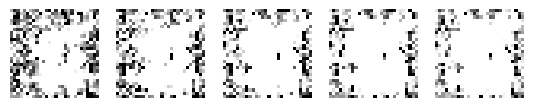

Epoch 1/4:  36%|███▋      | 199/546 [00:15<00:21, 15.81it/s, Loss=0.0636, MeanLoss=0.0589]

<Figure size 640x480 with 0 Axes>

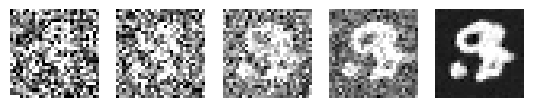

Epoch 1/4:  55%|█████▍    | 299/546 [00:23<00:15, 15.67it/s, Loss=0.0528, MeanLoss=0.0475]

<Figure size 640x480 with 0 Axes>

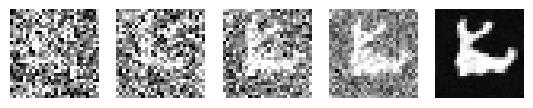

Epoch 1/4:  73%|███████▎  | 399/546 [00:31<00:09, 15.82it/s, Loss=0.0556, MeanLoss=0.0434]

<Figure size 640x480 with 0 Axes>

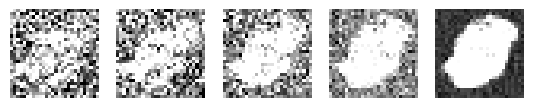

Epoch 1/4:  91%|█████████▏| 499/546 [00:39<00:02, 15.91it/s, Loss=0.0476, MeanLoss=0.0424]

<Figure size 640x480 with 0 Axes>

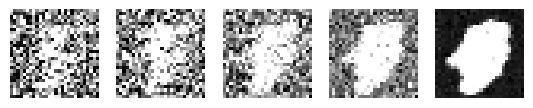

Epoch 1/4: 100%|██████████| 546/546 [00:44<00:00, 12.27it/s, Loss=0.0339, MeanLoss=0.0406]


<Figure size 640x480 with 0 Axes>

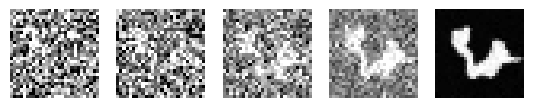

<Figure size 640x480 with 0 Axes>

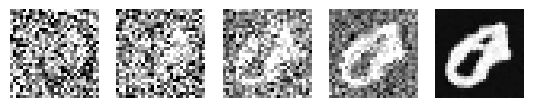

<Figure size 640x480 with 0 Axes>

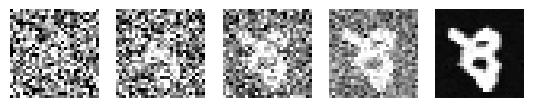

<Figure size 640x480 with 0 Axes>

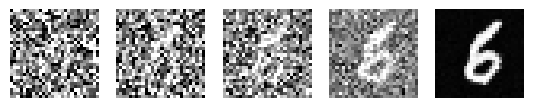

<Figure size 640x480 with 0 Axes>

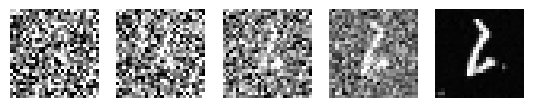

Epoch 3/4:  18%|█▊        | 100/546 [00:06<00:28, 15.49it/s, Loss=0.0289, MeanLoss=0.0351]

<Figure size 640x480 with 0 Axes>

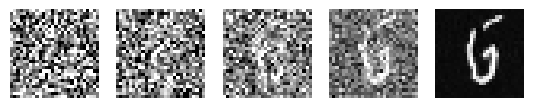

Epoch 3/4:  37%|███▋      | 200/546 [00:14<00:22, 15.44it/s, Loss=0.037, MeanLoss=0.0341] 

<Figure size 640x480 with 0 Axes>

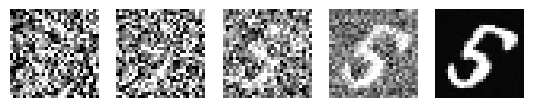

Epoch 3/4:  55%|█████▍    | 300/546 [00:23<00:15, 15.57it/s, Loss=0.0491, MeanLoss=0.034] 

<Figure size 640x480 with 0 Axes>

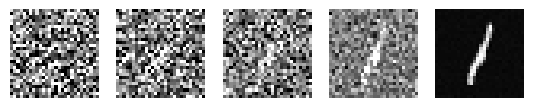

Epoch 3/4:  73%|███████▎  | 400/546 [00:31<00:09, 15.51it/s, Loss=0.033, MeanLoss=0.0337] 

<Figure size 640x480 with 0 Axes>

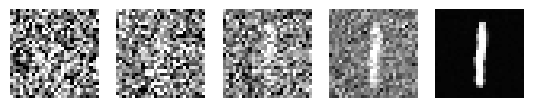

Epoch 3/4:  92%|█████████▏| 500/546 [00:39<00:02, 15.53it/s, Loss=0.0309, MeanLoss=0.033] 

<Figure size 640x480 with 0 Axes>

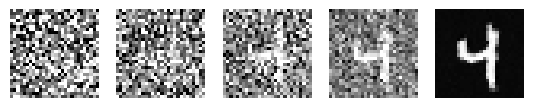

Epoch 3/4: 100%|██████████| 546/546 [00:44<00:00, 12.22it/s, Loss=0.0304, MeanLoss=0.0335]


<Figure size 640x480 with 0 Axes>

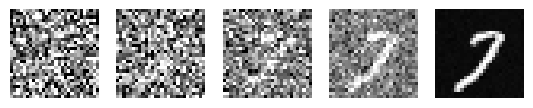

<Figure size 640x480 with 0 Axes>

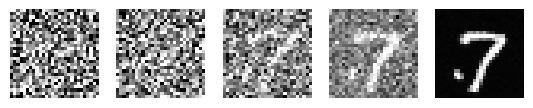

<Figure size 640x480 with 0 Axes>

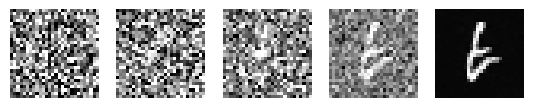

<Figure size 640x480 with 0 Axes>

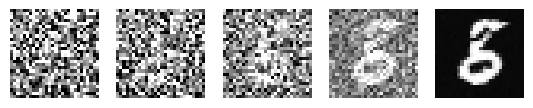

<Figure size 640x480 with 0 Axes>

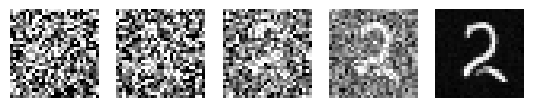

<Figure size 640x480 with 0 Axes>

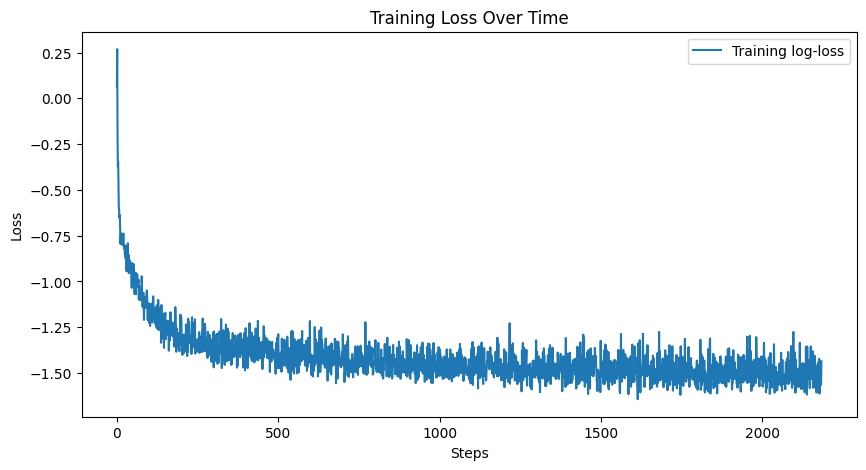

Epoch 4/4: 100%|██████████| 546/546 [00:45<00:00, 12.01it/s, Loss=0.0366, MeanLoss=0.032]


In [15]:
num_epochs = 4
losses, model = trainer.train(
    model=model,
    dataloader=dataloader,
    num_epochs=num_epochs,
    sampler=ddpm_sampler,
    plot=True,
)
torch.save(model, "model.pkl")

In [16]:
model = torch.load('model.pkl', weights_only=False)
classifier = torch.load('mnist_classifier.pkl',  weights_only=False)

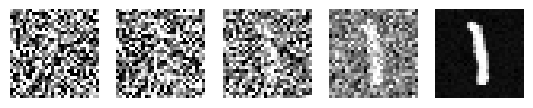

<Figure size 640x480 with 0 Axes>

In [151]:
vpsde_sampler = VPSDESampler(
    scheduler=scheduler, device=device, img_ch=IMG_CH, img_size=IMG_SIZE, ncols=ncols
)

img = vpsde_sampler.sample_images(model=model)
# img = torch.clamp(img, 0, 1)
# img = img.view(img.size(0), -1)
# mean_brightness = img.mean()

# print(f"Mean brightness of the generated image: {mean_brightness.item():.4f}")

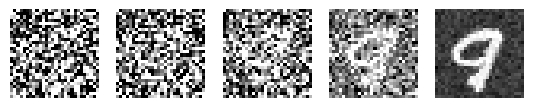

<Figure size 640x480 with 0 Axes>

In [193]:
gfuncs = [partial(classifier_constraint, classifier=classifier, target_class=9, epsilon=0.01)]
lmc_steps: int = 1
step_size: float = 1.8
step_size_lambda: float = 0.4

pdlmc_sampler = PDLMCSampler(
    scheduler=scheduler,
    device=device,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    ncols=ncols,
    gfuncs=gfuncs,
    lmc_steps=lmc_steps,
    step_size=step_size,
    step_size_lambda=step_size_lambda,
)

img = pdlmc_sampler.sample_images(model=model)
# img = torch.clamp(img, 0, 1)
# img = img.view(img.size(0), -1)
# mean_brightness = img.mean()

# print(f"Mean brightness of the generated image: {mean_brightness.item():.4f}")